<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>TODOs</a></span></li><li><span><a href="#Debugging" data-toc-modified-id="Debugging-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Debugging</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

This notebook is from Fall 2022. 
It uses data from the sentencing comission to model mandatory minimums policy in VA.

In [35]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import yearly_to_monthly_data
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 200)

In [36]:
mms_stats = pd.read_csv('../state/VA/2022/CurrentMMs.csv')
mms_stats = mms_stats[mms_stats.VCC.notnull()]
mms_stats['offense_code'] = mms_stats.VCC.apply(lambda x: x.split('-')[0] + x.split('-')[1])

In [37]:
crime_types = [
    'CONSPIRACY', 'DRUG_POSSESSION', 'DRUG_SALE', "DRUG_OTHER", "KIDNAPPING", "MANSLAUGHTER", "LARCENY", "WEAPON",
    "ASSAULT", "ROBBERY", "BURGLARY", "DWI", "RAPE", "SEX_OFFENSE", "ARSON", 'FIRST_DEGREE_MURDER',
    'SECOND_DEGREE_MURDER', 'OTHER_MURDER', 'CAPITAL_MURDER'
]

LOS_BY_CRIME = {
    'CONSPIRACY': 0.899,
    'DRUG_POSSESSION': 0.897,
    'DRUG_SALE': 0.902,
    'DRUG_OTHER': 0.901,
    'KIDNAPPING': 0.913,
    'MANSLAUGHTER': 0.916,
    'LARCENY': 0.907,
    'WEAPON': 0.905,
    'ASSAULT': 0.912,
    'ROBBERY': 0.920,
    'BURGLARY': 0.917,
    'DWI': 0.893,
    'RAPE': 0.906,
    'SEX_OFFENSE': 0.90,
    'ARSON': 0.914,
    'FIRST_DEGREE_MURDER': 0.907,
    'SECOND_DEGREE_MURDER': 0.914,
    'OTHER_MURDER': 0.908,
    'CAPITAL_MURDER': 0.898
}


In [38]:
# temp_data = pd.read_csv(f'../state/VA/VA_data/sentencing_data/sentencing_2021.csv')
# temp_data = temp_data.rename({
#     f'Offense {i} {term}': f'OFFENSE {i} {term.upper()}' for i in range(11) for term in ['VCC', 'Date', 'Counts']
# }, axis=1)
# temp_data = temp_data.rename({
#     'CCAP Long Program (FY2017-FY2020)' : 'CCAP Long',
#     'CCAP Short Program (FY2017-FY2020)': 'CCAP Short',
#     'Effective Sentence-Dys': 'Effective Sentence--Days',
#     'Effective Sentence-Life': 'Effective Sentence--Life',
#     'Effective Sentence-Mos': 'Effective Sentence--Months',
#     'Effective Sentence-Yrs': 'Effective Sentence--Years',
#     'Effective Sentence=Time Served': 'Effective Sentence-Time Served',
#     'Imposed Sent-Dys': 'Imposed Sentence-Dys',
#     'Imposed Sent-Life': 'Imposed Sentence-Life',
#     'Imposed Sent-Mos': 'Imposed Sentence-Mos',
#     'Imposed Sent-Yrs': 'Imposed Sentence-Yrs',
#     'Jury Sent-Days': 'Jury SentenceDays',
#     'Jury Sent-Life': 'Jury SentenceLife',
#     'Jury Sent-Months': 'Jury SentenceMonths',
#     'Jury Sent-Years': 'Jury SentenceYears',
#     'Probation Term-Dys (Not Captured until FY1998)': 'Probation Term - Dys (Not Captured until FY1998)',
#     'Probation Term-Mos (Not Captured until FY1998)': 'Probation Term - Mos (Not Captured until FY1998)',
#     'Probation Term-Yrs (Not Captured until FY1998)': 'Probation Term - Yrs (Not Captured until FY1998)',
# }, axis=1)
# temp_data.to_csv(f'../state/VA/VA_data/sentencing_data/sentencing_2021.csv', index=None)

In [39]:
temp21 = pd.read_csv(f'../state/VA/VA_data/sentencing_data/sentencing_2021.csv', encoding = "ISO-8859-1")
temp20 = pd.read_csv(f'../state/VA/VA_data/sentencing_data/sentencing_2020.csv', encoding = "ISO-8859-1")
set(temp20.columns).difference(temp21.columns)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (34,35,37,38,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


{'DJJCheckBox',
 'Document Control Number',
 'Effective Sentence (Judge+Alternative Sentencing)',
 'Effective Sentence (Judge-w/o Alternative Sentencing)',
 'Guidelines Preparer Name',
 'Guidelines Preparer Title',
 'Locality Name/Code (Based on FIPS)',
 'NVRA INELIG-CURRENT CAT I/II (FY2003-Present)',
 'NVRA INELIG-Current Mandatory Minimum (FY2003-Present)',
 'NVRA INELIG-PRIOR CAT I/II (FY2003-Present)',
 'NVRA INELIG-PROB (FY2003-Present)',
 'NVRA INELIG-QTY COCAINE (FY2003-Present)',
 'Non-Guidelines Offenses - Primary Offense VCC',
 'Nonviolent Risk Assessment (NVRA) Case',
 'Nonviolent Risk Assessment Alternative Recommendation - Cover Sheet',
 'Nonviolent Risk Form Error',
 'OK for Compliance Analysis - Coded Differently Prior to FY2007',
 'OK for NVRA Analysis',
 'Pris Rec High-Dys',
 'Pris Rec Low-Dys',
 'Pris Rec Midpoint-Dys',
 'Pris Rec Midpoint-Mos',
 'Pris Rec Midpoint-Yrs',
 'Recommended High',
 'Recommended Low',
 'Recommended Midpoint',
 'Revised NVRA  ARREST/CONFINEM

In [40]:
set(temp21.columns).difference(temp20.columns)

{'CCAP Program - Any (FY2021 and After)',
 'Commitment to Department of Juvenile Justice (DJJ) - Box Checked',
 'Document Control Number - SG Data System',
 'Locality Name/ Code (Based on FIPS)',
 'NV Risk Asmt Alternative Recommendation - Cover Sheet',
 'NVRA >=26 Yrs Old & Never Married (FY2003-FY2013)',
 'NVRA Additional Offense (FY2003-FY2013)',
 'NVRA Age (FY2003-FY2013)',
 'NVRA Arrest/Confinement Past 18 Mos. (FY2003-FY2013)',
 'NVRA Ineligible-Current Cat I/II (FY2003-Present)',
 'NVRA Ineligible-Current Mandatory Minimum (FY2003-Present)',
 'NVRA Ineligible-Prior Cat I/II (FY2003-Present)',
 'NVRA Ineligible-Prob (FY2003-Present)',
 'NVRA Ineligible-Qty Cocaine (FY2003-Present)',
 'NVRA Male (FY2003-FY2013)',
 'NVRA Not Regularly Employed (FY2003-FY2013)',
 'NVRA Offense Type (FY2003-FY2013)',
 'NVRA Prior Adult Incarceration (FY2003-FY2013)',
 'NVRA Prior Felony Conv/Adjudication (FY2003-FY2013)',
 'NVRA Sum of Offender Factors',
 'NVRA Total Score (FY2003-FY2013)',
 'NonSG O

In [41]:
raw_sent = pd.concat([
    pd.read_csv(f'../state/VA/VA_data/sentencing_data/sentencing_{i}.csv', encoding = "ISO-8859-1") for i in range(2019,2022)
])
raw_sent = raw_sent.drop(set(temp21.columns).difference(temp20.columns), axis=1)
raw_sent = raw_sent.drop(set(temp20.columns).difference(temp21.columns), axis=1)

raw_sent = raw_sent.rename({
    'OFFENSE 1 VCC': 'crime',
    'Type of Primary Offense': 'crime_type',
    'Code Section of Primary (Most Serious) Offense': 'code_section',
    'Drug Offense involved Cocaine (Not Captured until FY2018)': 'cocaine_drug_crime',
    'Drug Offense involved Codeine (Not Captured until FY2018)': 'codeine_drug_crime',
    'Drug Offense involved Fentanyl (Not Captured until FY2018)': 'fentanyl_drug_crime',
    'Drug Offense involved Heroin (Not Captured until FY2018)': 'heroin_drug_crime',
    'Drug Offense involved Hydrocodone (Not Captured until FY2018)': 'hydrocodone_drug_crime',
    'Drug Offense involved Methadone (Not Captured until FY2018)': 'methadone_drug_crime',
    'Drug Offense involved Methamphetamine (Not Captured until FY2018)': 'meth_drug_crime',
    'Drug Offense involved Methylphenidate (Not Captured until FY2018)': 'methylphenidate_drug_crime',
    'Drug Offense involved Morphine (Not Captured until FY2018)': 'morphine_drug_crime',
    'Drug Offense involved Oxycodone (Not Captured until FY2018)': 'oxycodone_drug_crime',
    'Drug Offense involved Other Drug (Not Captured until FY2018)': 'other_drug_crime',
    'Section B Mandatory Minimum - Yrs (Not Captured until FY2002)': 'MM_years',
    'Section B Mandatory Minimum - Mos (Not Captured until FY2002)': 'MM_months',
    'Section B Mandatory Minimum - Dys (Not Captured until FY2002)': 'MM_days',
    'Section C Recommendation Adjusted for Mandatory Minimum': 'MM_adjustment',
    'Imposed Sentence-Life': 'imposed_life',
    'Imposed Sentence-Mos': 'imposed_months',
    'Imposed Sentence-Dys': 'imposed_days',
    'Imposed Sentence-Yrs': 'imposed_years',
    'Effective Sentence--Life': 'imposed_life',
    'Effective Sentence--Months': 'effective_months',
    'Effective Sentence--Days': 'effective_days',
    'Effective Sentence--Years': 'effective_years',
    'Effective Sentence-Time Served': 'effective_time_served',
    'Calendar Year of Sentencing': 'calendar_year',
    'Fiscal Year of Sentencing': 'fiscal_year'
}, axis=1)

raw_sent = raw_sent[raw_sent.crime.notnull()]
raw_sent['crime_level'] = raw_sent.crime.apply(lambda x: x[-2:])
raw_sent.crime = raw_sent.crime.apply(lambda x: x[:-2])
raw_sent['effective_sentence_months'] = raw_sent.effective_years * 12 + raw_sent.effective_months + (raw_sent.effective_days * 12 / 365.25).apply(round)
raw_sent['sentence_months'] = raw_sent.imposed_years * 12 + raw_sent.imposed_months + (raw_sent.imposed_days * 12 / 365.25).apply(round)

raw_sent.head()

/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_10107/2658142090.py:1: DtypeWarning: Columns (40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_sent = pd.concat([
/var/folders/3l/phmqvp1s6y5_l56qp_wwfrb80000gn/T/ipykernel_10107/2658142090.py:1: DtypeWarning: Columns (34,35,37,38,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  raw_sent = pd.concat([


,calendar_year,fiscal_year,Offender Birth Month,Offender Birth Year,Judicial Circuit,Commonwealth Attorney Last Name,Defense Attorney Last Name,crime_type,OFFENSE 1 COUNTS,crime,OFFENSE 1 DATE,OFFENSE 2 COUNTS,OFFENSE 2 VCC,OFFENSE 2 DATE,OFFENSE 3 COUNTS,OFFENSE 3 VCC,OFFENSE 3 DATE,OFFENSE 4 COUNTS,OFFENSE 4 VCC,OFFENSE 4 DATE,OFFENSE 5 COUNTS,OFFENSE 5 VCC,OFFENSE 5 DATE,OFFENSE 6 COUNTS,OFFENSE 6 VCC,OFFENSE 6 DATE,OFFENSE 7 COUNTS,OFFENSE 7 VCC,OFFENSE 7 DATE,OFFENSE 8 COUNTS,OFFENSE 8 VCC,OFFENSE 8 DATE,OFFENSE 9 COUNTS,OFFENSE 9 VCC,OFFENSE 9 DATE,OFFENSE 10 COUNTS,OFFENSE 10 VCC,OFFENSE 10 DATE,code_section,Docket Number,cocaine_drug_crime,codeine_drug_crime,fentanyl_drug_crime,heroin_drug_crime,hydrocodone_drug_crime,methadone_drug_crime,meth_drug_crime,methylphenidate_drug_crime,morphine_drug_crime,oxycodone_drug_crime,other_drug_crime,Drug Offense involved Other Drug - Name of Drug (Not Captured until FY2018),Trial Type,Jury SentenceYears,Jury SentenceMonths,Jury SentenceDays,Jury SentenceLife,Juvenile Jury Case,Jury Imposed Fine,SG Recommendation,MM_years,MM_months,MM_days,Prison Recommendation,Pris Rec Low-Yrs,Pris Rec Low-Mos,Pris Rec High-Yrs,Pris Rec High-Mos,MM_adjustment,imposed_life,imposed_years,imposed_months,imposed_days,imposed_life,effective_years,effective_months,effective_days,effective_time_served,Post Release Term-Yrs,Post Release Term-Mos,Post Release Term-Dys,Post Release Supervision Period-Yrs,Post Release Supervision Period-Mos,Post Release Supervision Period-Dys,Indefinite Term of Probation (Not Captured until FY1998),Probation Term - Yrs (Not Captured until FY1998),Probation Term - Mos (Not Captured until FY1998),Probation Term - Dys (Not Captured until FY1998),Term of Good Behavior-Yrs (Not Captured until late FY2017),Term of Good Behavior-Mos (Not Captured until late FY2017),Term of Good Behavior-Dys (Not Captured until late FY2017),Sentence to Run Concurrently w/Another (Not Captured until FY2001),Type of Plea Agreement,Restitution Ordered,Fine Ordered,Day Reporting Program,Diversion Center,Electronic Monitoring,Unsupervised Probation (Not Captured until FY1998),First Offender,Substance Abuse Treatment (Not Captured until FY2011),CCCA,CCCATYPE,CCAP Short,CCAP Long,Detention Center,Drug Court (Not Captured until FY2001),Intensive Supervision,Youthful Offender Program,Other Sanction,Other Sanction 1-Type,Other Sanction 2-Type,Other Sanction 3-Type,Other Sanction 4-Type,Departure Code 1,Departure Code 2,Departure Code 3,Sentence Date,Worksheet Year,Section A-Score 1,Section A-Score 2,Section A-Score 3,Section A-Score 4,Section A-Score 5,Section A-Score 6,Section A-Score 7,Section A-Score 8,Section A-Score 9,Section A-Score 10,Section A-Score 11,Section A-Score 12,Section A-Score 13,Section A-Score 14,Section A-Total Score,Section B-Score 1,Section B-Score 2,Section B-Score 3,Section B-Score 4,Section B-Score 5,Section B-Score 6,Section B-Score 7,Section B-Score 8,Section B-Score 9,Section B-Score 10,Section B-Score 11,Section B-Score 12,Section B-Score 13,Section B-Total Score,Prior Record Category,Section C-Score 1,Section C-Score 2,Section C-Score 3,Section C-Score 4,Section C-Score 5,Section C-Score 6,Section C-Score 7,Section C-Score 8,Section C-Score 9,Section C-Score 10,Section C-Score 11,Section C-Score 12,Section C-Score 13,Section C-Total Score,Section C-Life,Section C-Detention Center,NVRA Alternative Recommendation - Section D,Sex Offender Risk Assessment (SORA) Applicability,Sex Offender Risk Asmt Adjustment - Section A,Risk Assessment Recommendation and Sentence Outcome,Sentence Concurrence with (or Departure from) Guidelines,crime_level,effective_sentence_months,sentence_months
0,2018,2019,1.0,1992.0,2,J. SPENCER MORG,CARL H. BUNDICK,WEAPON,2.0,WPN5298,11/16/2017,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,18.2-308.2(A),CR18000043,No,No,No,No,No,No,No,No,No,No,No,NaN,Guilty Plea,NaN,NaN,NaN,NaN,NaN,NaN,Incarc > 6M,0,

In [42]:
raw_sent[raw_sent.cocaine_drug_crime.map({'No': False, 'Yes': True})].groupby('crime').count().max(axis=1)

crime
ASL1335       1
BUR2216       1
DWI5449       1
FAM3808       1
FRD2360       2
FRD2519       1
FRD2520       1
FRD2521       1
FTA5019       1
KID1010       1
LAR2354       1
LAR2359       6
LAR2369       1
LAR2383       1
NAR3004       1
NAR3022    5683
NAR3032      48
NAR3033       1
NAR3035     148
NAR3038     296
NAR3042     590
NAR3043     914
NAR3044       3
NAR3045     386
NAR3061       9
NAR3073     137
NAR3085       2
NAR3087      79
NAR3135       3
NAR3136       2
NON0000       5
PRI3261       1
REC6624       1
WPN5281       1
WPN5291       1
WPN5297       1
WPN5298       1
dtype: int64

In [43]:
raw_va_sentence_df = pd.read_csv(
    '../state/VA/VA_data/unprocessed_va_historical_sentences_v2.csv',
    sep='\t'
)
raw_va_sentence_df['crime_type'] = raw_va_sentence_df['Offense Group'].ffill()
raw_va_sentence_df['crime'] = raw_va_sentence_df['VCC'].ffill()
raw_va_sentence_df['judge_id'] = raw_va_sentence_df['JudgeID'].ffill()
raw_va_sentence_df['sentence_type_code'] = raw_va_sentence_df['ActDisp'].ffill()
raw_va_sentence_df['effective_sentence_months'] = raw_va_sentence_df['effsent']
raw_va_sentence_df['fiscal_year'] = raw_va_sentence_df['FiscalYr'].ffill()
raw_va_sentence_df['life_sentence'] = raw_va_sentence_df['EffLif']
raw_va_sentence_df = raw_va_sentence_df.rename({'Off1Date':'offense_date'}, axis=1)

raw_va_sentence_df = raw_va_sentence_df[~raw_va_sentence_df['crime_type'].str.contains('Total')]


raw_va_sentence_df = raw_va_sentence_df.drop(
    ['Offense Group', 'VCC', 'Off1VCC', 'JudgeID', 'ActDisp', 'effsent', 'FiscalYr', 'EffLif'],
    axis=1
)
raw_va_sentence_df.head()

,offense_date,OffLName,OffFName,crime_type,crime,judge_id,sentence_type_code,effective_sentence_months,fiscal_year,life_sentence
0,5/20/2017,MOORE,KENNETH,ASSAULT,ASL1316,0,3.0,18.0,2018.0,0.0
1,4/25/2018,CLINE,MATTHEW,ASSAULT,ASL1316,0,3.0,10.0,2019.0,0.0
2,11/11/2017,TINSLEY,JAVON,ASSAULT,ASL1316,10DB,1.0,0.0,2018.0,0.0
3,6/8/2015,COMPTON,ROBERT,ASSAULT,ASL1316,10DB,2.0,0.0,2017.0,0.0
4,12/25/2016,MILLER,MARCUS,ASSAULT,ASL1316,10DB,3.0,7.0,2017.0,0.0


<AxesSubplot:xlabel='effective_sentence_months'>

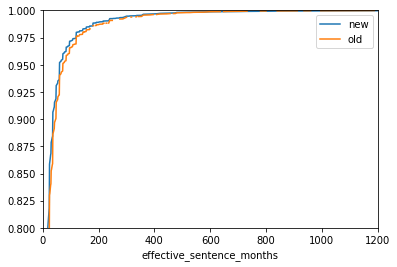

In [44]:
raw_sent['effective_sentence_months'] = raw_sent.effective_years * 12 + raw_sent.effective_months + (raw_sent.effective_days * 12 / 365.25).apply(round)
a = pd.DataFrame()
a['new'] = raw_sent.groupby('effective_sentence_months').count().max(axis=1)
a['old'] = raw_va_sentence_df.groupby('effective_sentence_months').count().max(axis=1)

a.new = a.new.cumsum() / a.new.sum()
a.old = a.old.cumsum() / a.old.sum()

a.plot(xlim=[0,1200], ylim=[0.8,1])
# plt.yscale('log')

<AxesSubplot:xlabel='effective_sentence_months'>

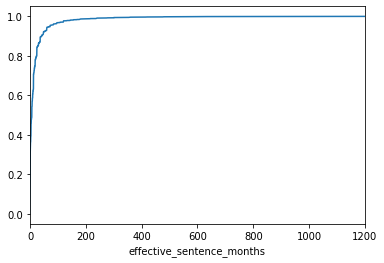

In [45]:
b = raw_va_sentence_df.groupby('effective_sentence_months').count().max(axis=1)
b = b.cumsum()/b.sum()
b.plot(xlim=[0,1200])

In [46]:
raw_va_sentence_df.groupby('fiscal_year').count().max(axis=1)

fiscal_year
2017.0    24666
2018.0    24646
2019.0    24990
dtype: int64

In [47]:
def count_instances(crime_code):
    return len(raw_sent[raw_sent.crime == crime_code])

mms_stats['instances'] = mms_stats.offense_code.apply(count_instances)
# plt.hist(mms_stats.instances / mms_stats.instances.sum(), bins=40)
# plt.yscale('log')
mms_stats = mms_stats.set_index('DESCRTN')
mms_stats.sort_values('instances', ascending=False)

,CHAPTER,CHAPDEC,SECTION,SCPUNCT,SUBSECT,PARAGRF,STATUTE,EFFDATE,DateAdd,SGOFF,SENTENCE,MAN_MIN,MAN_UNIT,RETIREDATE,MM,MM_clean,VCC,IBRCODE,FelonyTimeServed,HEADING,SUBHEAD,offense_code,instances
DESCRTN,,,,,,,,,,,,,,,,,,,,,,,
"Simple assault on law enforcement, court, DOC, fire/medical, etc.",18,2,57,NaN,NaN,C,18.2-57(C),7/1/97,7/1/97,Y,1Y-5Y,6,M,NaN,6 M,6,ASL-1342-F6,NaN,3,ASSAULT,"Law Enforcement, Court, Fire, Medical Services...",ASL1342,1216
"Convicted felon (non-violent w/in 10 yr.) possess firearm, etc.",18,2,308,.,2,A,18.2-308.2(A),7/1/99,7/1/99,Y,1Y-5Y (II),2,Y,NaN,2 Y,24,WPN-5297-F6,NaN,3,WEAPONS,Felon,WPN5297,683
"Sell, poss. w/intent, distribute, etc. - second conviction",18,2,248,NaN,NaN,C,18.2-248(C),7/1/12,7/1/12,Y,5Y-Life,3,Y,NaN,3 Y,36,NAR-3038-F9,NaN,3,NARCOTICS,"Schedule I or II Drugs - Distribution, 2nd",NAR3038,634
Third conviction within 10 years,18,2,266,NaN,NaN,NaN,18.2-266,7/1/04,7/1/04,Y,1Y-5Y,90,D,NaN,90 D,3,DWI-5449-F6,NaN,3,TRAFFIC - DRIVING WHILE INTOXICATED,"Motor Vehicle, Etc. - 3rd Conviction",DWI5449,613
Third conviction within 5 Years,18,2,266,NaN,NaN,NaN,18.2-266,7/1/04,7/1/04,Y,1Y-5Y,6,M,NaN,6 M,6,DWI-5450-F6,NaN,3,TRAFFIC - DRIVING WHILE INTOXICATED,"Motor Vehicle, Etc. - 3rd Conviction",DWI5450,297
Convicted felon (violent) possess/transport firearm,18,2,308,.,2,A,18.2-308.2(A),7/1/99,7/1/99,Y,1Y-5Y (II),5,Y,NaN,5 Y,60,WPN-5296-F6,NaN,3,WEAPONS,Felon,WPN5296,212
"Sell, poss. w/intent, distribute, etc. - third or subsequent",18,2,248,NaN,NaN,C,18.2-248(C),7/1/12,7/1/12,Y,10Y-Life,10,Y,NaN,10 Y,120,NAR-3087-F9,NaN,3,NARCOTICS,"Schedule I or II Drugs - Distribution, 3rd & S...",NAR3087,155
Propose sex act by communications sys. age,18,2,374,.,3,C,18.2-374.3(C),7/1/07,7/1/07,Y,5Y-30Y (II),5,Y,NaN,5 Y,60,OBS-3702-F9,NaN,1,OBSCENITY - CHILD SOLICITATION,Communications System,OBS3702,132
"Prior DWI manslaughter, assault, felony DWI",18,2,266,NaN,NaN,NaN,18.2-266,7/1/13,7/1/13,Y,1Y-5Y,1,Y,NaN,1 Y,12,DWI-5493-F6,NaN,3,TRAFFIC - DRIVING WHILE INTOXICATED,"Motor Vehicle, Etc. - A Prior Felony § 18.2-27...",DWI5493,113


# Preprocessing

## TODOs
* can't just drop 0 length sentences
* probation
* recidivism
* separate out jail
* total population data

* dropping crimes w no VCC
* what's going on with the spike at 10 yrs for drug sale
* Check that court data matches sentencing data for mm crimes
* compare just most serious crime vs 'any' tag
* fix dedup to remove overlaps (see cell below this one)
* add in other mms and especially LIC6860

In [48]:
# combined_data = pd.concat([
#     raw_va_sentence_df.loc[raw_va_sentence_df.fiscal_year != 2019, ['crime', 'fiscal_year', 'effective_sentence_months']],
#     raw_sent[['crime', 'fiscal_year','effective_sentence_months']]
# ])

combined_data = raw_sent[raw_sent.effective_sentence_months > 0]
combined_data.loc[combined_data.effective_sentence_months > 12 * 50, 'effective_sentence_months'] = 12 * 50

def combine_non_mms(x):
    if x in mms_stats.offense_code.unique():
        return x
    return 'other'

combined_data.crime = combined_data.crime.apply(combine_non_mms)

outflows_data = combined_data.copy()


outflows_data['time_step'] = outflows_data.fiscal_year - 2020
outflows_data = outflows_data.groupby(['time_step', 'crime']).count()[['fiscal_year']].reset_index().rename(
    {'fiscal_year': 'total_population'}, axis=1
)
outflows_data = yearly_to_monthly_data(outflows_data)


outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,time_step,crime,total_population,compartment,outflow_to
0,-12,ASL1319,0.083333,pretrial,prison
1,-12,ASL1326,0.500000,pretrial,prison
2,-12,ASL1330,0.083333,pretrial,prison
3,-12,ASL1342,39.500000,pretrial,prison
4,-12,DWI5406,4.333333,pretrial,prison


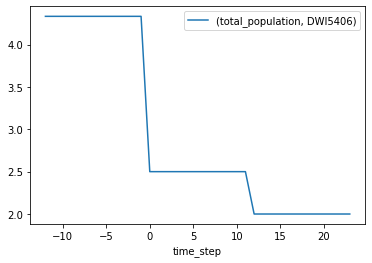

In [49]:
outflows_data.groupby(['crime', 'time_step']).sum().unstack('crime').iloc[:,4].plot()
plt.legend(bbox_to_anchor=[1,1])

In [50]:
combined_data.head()

,calendar_year,fiscal_year,Offender Birth Month,Offender Birth Year,Judicial Circuit,Commonwealth Attorney Last Name,Defense Attorney Last Name,crime_type,OFFENSE 1 COUNTS,crime,OFFENSE 1 DATE,OFFENSE 2 COUNTS,OFFENSE 2 VCC,OFFENSE 2 DATE,OFFENSE 3 COUNTS,OFFENSE 3 VCC,OFFENSE 3 DATE,OFFENSE 4 COUNTS,OFFENSE 4 VCC,OFFENSE 4 DATE,OFFENSE 5 COUNTS,OFFENSE 5 VCC,OFFENSE 5 DATE,OFFENSE 6 COUNTS,OFFENSE 6 VCC,OFFENSE 6 DATE,OFFENSE 7 COUNTS,OFFENSE 7 VCC,OFFENSE 7 DATE,OFFENSE 8 COUNTS,OFFENSE 8 VCC,OFFENSE 8 DATE,OFFENSE 9 COUNTS,OFFENSE 9 VCC,OFFENSE 9 DATE,OFFENSE 10 COUNTS,OFFENSE 10 VCC,OFFENSE 10 DATE,code_section,Docket Number,cocaine_drug_crime,codeine_drug_crime,fentanyl_drug_crime,heroin_drug_crime,hydrocodone_drug_crime,methadone_drug_crime,meth_drug_crime,methylphenidate_drug_crime,morphine_drug_crime,oxycodone_drug_crime,other_drug_crime,Drug Offense involved Other Drug - Name of Drug (Not Captured until FY2018),Trial Type,Jury SentenceYears,Jury SentenceMonths,Jury SentenceDays,Jury SentenceLife,Juvenile Jury Case,Jury Imposed Fine,SG Recommendation,MM_years,MM_months,MM_days,Prison Recommendation,Pris Rec Low-Yrs,Pris Rec Low-Mos,Pris Rec High-Yrs,Pris Rec High-Mos,MM_adjustment,imposed_life,imposed_years,imposed_months,imposed_days,imposed_life,effective_years,effective_months,effective_days,effective_time_served,Post Release Term-Yrs,Post Release Term-Mos,Post Release Term-Dys,Post Release Supervision Period-Yrs,Post Release Supervision Period-Mos,Post Release Supervision Period-Dys,Indefinite Term of Probation (Not Captured until FY1998),Probation Term - Yrs (Not Captured until FY1998),Probation Term - Mos (Not Captured until FY1998),Probation Term - Dys (Not Captured until FY1998),Term of Good Behavior-Yrs (Not Captured until late FY2017),Term of Good Behavior-Mos (Not Captured until late FY2017),Term of Good Behavior-Dys (Not Captured until late FY2017),Sentence to Run Concurrently w/Another (Not Captured until FY2001),Type of Plea Agreement,Restitution Ordered,Fine Ordered,Day Reporting Program,Diversion Center,Electronic Monitoring,Unsupervised Probation (Not Captured until FY1998),First Offender,Substance Abuse Treatment (Not Captured until FY2011),CCCA,CCCATYPE,CCAP Short,CCAP Long,Detention Center,Drug Court (Not Captured until FY2001),Intensive Supervision,Youthful Offender Program,Other Sanction,Other Sanction 1-Type,Other Sanction 2-Type,Other Sanction 3-Type,Other Sanction 4-Type,Departure Code 1,Departure Code 2,Departure Code 3,Sentence Date,Worksheet Year,Section A-Score 1,Section A-Score 2,Section A-Score 3,Section A-Score 4,Section A-Score 5,Section A-Score 6,Section A-Score 7,Section A-Score 8,Section A-Score 9,Section A-Score 10,Section A-Score 11,Section A-Score 12,Section A-Score 13,Section A-Score 14,Section A-Total Score,Section B-Score 1,Section B-Score 2,Section B-Score 3,Section B-Score 4,Section B-Score 5,Section B-Score 6,Section B-Score 7,Section B-Score 8,Section B-Score 9,Section B-Score 10,Section B-Score 11,Section B-Score 12,Section B-Score 13,Section B-Total Score,Prior Record Category,Section C-Score 1,Section C-Score 2,Section C-Score 3,Section C-Score 4,Section C-Score 5,Section C-Score 6,Section C-Score 7,Section C-Score 8,Section C-Score 9,Section C-Score 10,Section C-Score 11,Section C-Score 12,Section C-Score 13,Section C-Total Score,Section C-Life,Section C-Detention Center,NVRA Alternative Recommendation - Section D,Sex Offender Risk Assessment (SORA) Applicability,Sex Offender Risk Asmt Adjustment - Section A,Risk Assessment Recommendation and Sentence Outcome,Sentence Concurrence with (or Departure from) Guidelines,crime_level,effective_sentence_months,sentence_months
0,2018,2019,1.0,1992.0,2,J. SPENCER MORG,CARL H. BUNDICK,WEAPON,2.0,other,11/16/2017,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,18.2-308.2(A),CR18000043,No,No,No,No,No,No,No,No,No,No,No,NaN,Guilty Plea,NaN,NaN,NaN,NaN,NaN,NaN,Incarc > 6M,0,0,

In [51]:
transitions_data = combined_data.copy()
transitions_data = transitions_data.groupby(
    ['effective_sentence_months', 'crime']
).count()[['fiscal_year']].reset_index().rename({
    'fiscal_year': 'total_population', 'effective_sentence_months':'compartment_duration'
}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'

non_enhanced_transitions = combined_data.copy()
non_enhanced_transitions = non_enhanced_transitions.groupby(
    ['effective_sentence_months', 'crime']
).count()[['fiscal_year']].reset_index().rename({
    'fiscal_year': 'total_population', 'effective_sentence_months':'compartment_duration'
}, axis=1)
non_enhanced_transitions['compartment'] = 'prison'
non_enhanced_transitions['outflow_to'] = 'release'


crime_types = transitions_data.crime.unique()
# taken from here (https://vadoc.virginia.gov/media/1681/vadoc-recidivism-re-arrest-rates-report-2016.pdf)
RECIDIVISM_BY_CRIME_TYPE = {
    'ASL': 0.246,
    'DWI': 0.184,
    'LIC': 0.184,
    'RAP': 0.226,
    'OBS': 0.25,        
    'WPN': 0.209,
    'NAR': 0.193,
    'ESC': 0.232,
    'MUR': 0.073,
    'oth': 0.232
}

# taken from https://vadoc.virginia.gov/media/1680/vadoc-state-recidivism-report-2021-05.pdf
RECIDIVISM_BY_MONTHS_SINCE_RELEASE = {
    6: (1.1 + 1.3 + 1.5 + 1.3  + 1.3 + 1.2) / 6,
    12: (4.3 + 5 + 4.9 + 5 + 4.9 + 4.6) / 6,
    18: (9.6 + 10.1 + 9.9 + 10.1 + 9.8) / 5,
    24: (15.0 + 15.3 + 15.0 + 15.6) / 4,
    36: (22.4 + 23.4 + 23.1 + 23.9) / 4
}
recidivism_transitions = pd.DataFrame({
    'compartment': ['release'] * 36,
    'outflow_to': ['prison'] * 36,
    'compartment_duration': range(1, 37),
    'total_population': (
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[6] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[12] / 6] * 6 +
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[18] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[24] / 6] * 6 + 
        [RECIDIVISM_BY_MONTHS_SINCE_RELEASE[36] / 12] * 12
    )
})

for crime in crime_types:
    crime_type = crime[:3]
    crime_recidivism = recidivism_transitions.copy()
    total_recidivism = sum(RECIDIVISM_BY_MONTHS_SINCE_RELEASE.values())
    crime_specific_total_recidivism = RECIDIVISM_BY_CRIME_TYPE[crime_type]
    crime_recidivism.total_population *= crime_specific_total_recidivism / total_recidivism
    crime_recidivism = crime_recidivism.append({
        'compartment_duration': 36,
        'total_population': 1 - crime_specific_total_recidivism,
        'compartment': 'release',
        'outflow_to': 'release_full',
    }, ignore_index=True)
    crime_recidivism['crime'] = crime
    
    transitions_data = transitions_data.append(crime_recidivism)
    
    # adjust outflows so we're not double counting recidivism
    outflows_data.loc[
        outflows_data.crime == crime, 'total_population'
    ] /= 1 + crime_specific_total_recidivism


transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * len(crime_types),
    'total_population': [1] * len(crime_types),
    'compartment': ['release_full'] * len(crime_types),
    'outflow_to': ['release_full'] * len(crime_types),
    'crime': crime_types,
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.compartment_duration = transitions_data.compartment_duration.astype(float)
transitions_data.head()

,compartment_duration,crime,total_population,compartment,outflow_to
0,1.0,ASL1342,3.0,prison,release
1,1.0,DWI5449,2.0,prison,release
2,1.0,NAR3038,1.0,prison,release
3,1.0,WPN5297,1.0,prison,release
4,1.0,other,3329.0,prison,release


In [52]:
# Total population data

total_pop = {
    2021: [23811, 23644, 23769, 23897, 23966, 24229, 24467, 24625, 24694, 24738],
    2020: [29223, 29208, 29136, 28595, 27871, 27294, 26749, 26190, 25659, 25156, 24731, 24235],
    2019: [29708, 29859, 29992, 30014, 30028, 29995, 30049, 29857, 29696, 29664, 29392, 29347]
    
}

total_population_data = pd.DataFrame({
    'time_step': range(34),
    'total_population': total_pop[2019] + total_pop[2020] + total_pop[2021]
})
total_population_data['compartment'] = 'prison'
total_population_data.total_population = total_population_data.total_population.astype(float)


In [53]:
simulation_tag = "mms_dec_29"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    total_population_data,
    '../state/VA/2022/policy_configurations/mms_model_inputs.yaml',
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
1it [00:03,  3.95s/it]
1it [00:06,  6.73s/it]
1it [00:07,  7.33s/it]


## Debugging

(array([  4.,   1.,   4.,   1.,   3.,   3.,   4.,   2.,   1.,   6.,   1.,
          4.,   1.,   1., 177.,  13.,  16.,   7.,   3.,  49.,   5.,  12.,
          3.,   4.,  56.,   2.,   8.,   3.,  60.,   3.,   4.,  12.,   0.,
         29.,   0.,   3.,   6.,   3.,  30.,   3.]),
 array([ 1.  ,  3.45,  5.9 ,  8.35, 10.8 , 13.25, 15.7 , 18.15, 20.6 ,
        23.05, 25.5 , 27.95, 30.4 , 32.85, 35.3 , 37.75, 40.2 , 42.65,
        45.1 , 47.55, 50.  , 52.45, 54.9 , 57.35, 59.8 , 62.25, 64.7 ,
        67.15, 69.6 , 72.05, 74.5 , 76.95, 79.4 , 81.85, 84.3 , 86.75,
        89.2 , 91.65, 94.1 , 96.55, 99.  ]),
 <BarContainer object of 40 artists>)

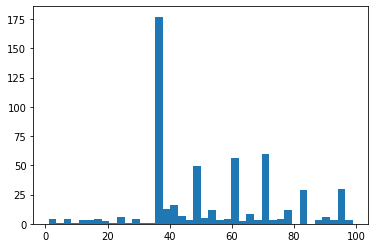

In [54]:
#ASL1342 assault police officer --> 6 months
plt.hist(combined_data[(combined_data.crime == 'NAR3038') & 
                            (combined_data.effective_sentence_months <= 100)].effective_sentence_months, bins=40)

# Modeling

In [59]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/policy_configurations/mms_model_inputs.yaml'
)

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1416/1416 [00:00<00:00, 3746.27rows/s]
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1967: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  df[column] = pandas.Series(df[column], dtype=dtypes[column])


outflows_data returned 1416 results


Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2546/2546 [00:00<00:00, 5838.75rows/s]


transitions_data returned 2546 results


Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 125.54rows/s]
crime    compartment  outflow_to
ASL1319  pretrial     prison        33.333333
DWI5693  pretrial     prison        66.666667
NAR3085  pretrial     prison        33.333333
NAR3097  pretrial     prison        33.333333
OBS3686  pretrial     prison        66.666667
OBS3691  pretrial     prison        33.333333
OBS3742  pretrial     prison        66.666667
OBS3745  pretrial     prison        33.333333
OBS3749  pretrial     prison        66.666667
OBS3754  pretrial     prison        33.333333
OBS3757  pretrial     prison        66.666667
OBS3760  pretrial     prison        33.333333
dtype: float64%


total_population_data returned 34 results


initialization time:  355.3713481426239


simulation_time:  402.11037588119507


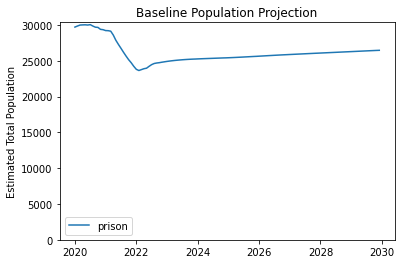

In [129]:
spark_sim.simulate_baseline(['prison'])

../../../../../recidiviz/calculator/modeling/population_projection/super_simulation/validator.py:113: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(figsize=fig_size)


[<AxesSubplot:title={'center':'simulation_group: ASL1319\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ASL1326\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ASL1330\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: ASL1342\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: DWI5406\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: DWI5449\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: DWI5450\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: DWI5493\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSu

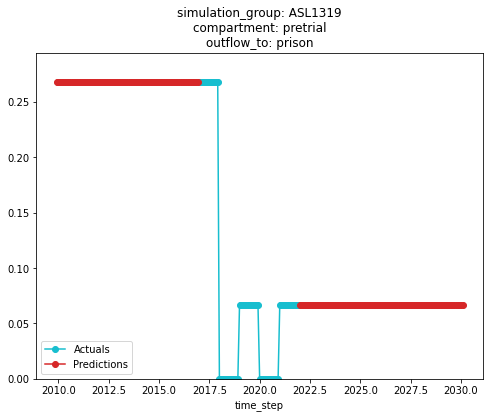

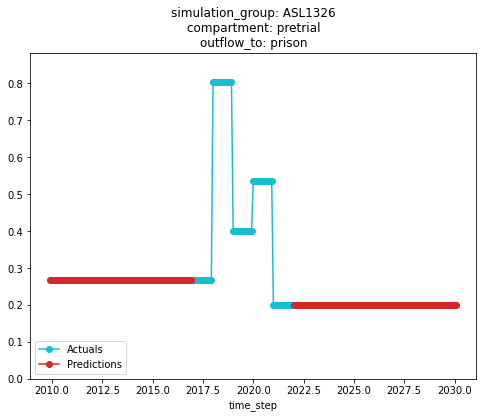

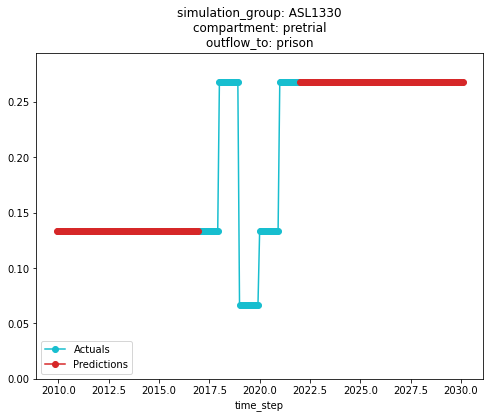

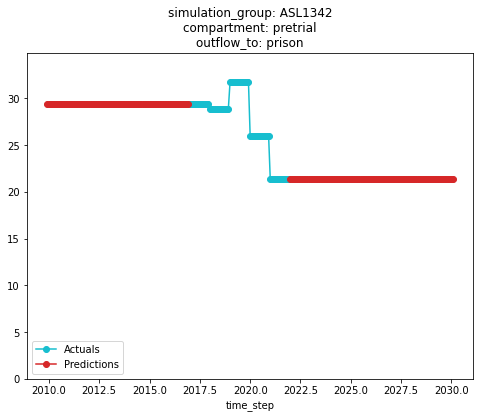

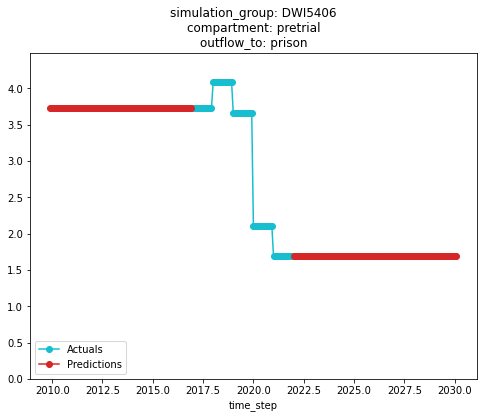

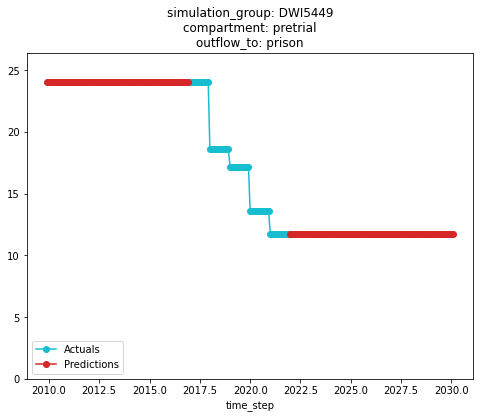

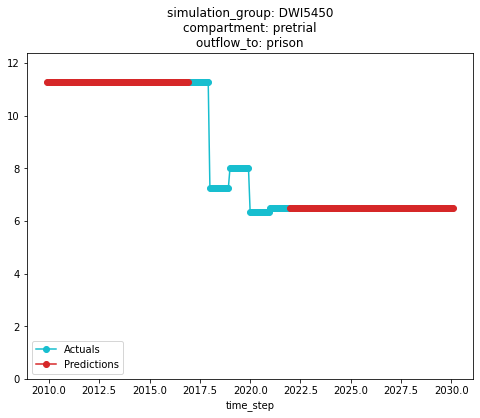

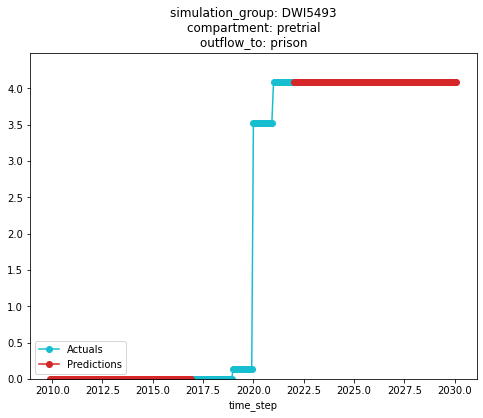

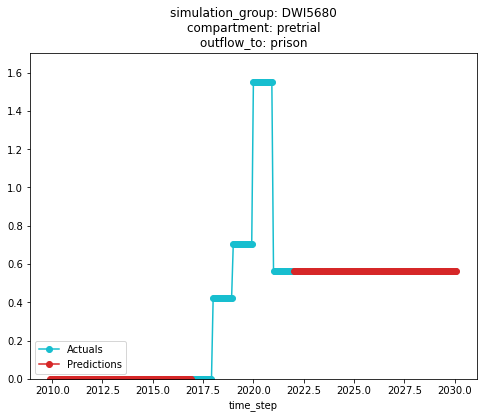

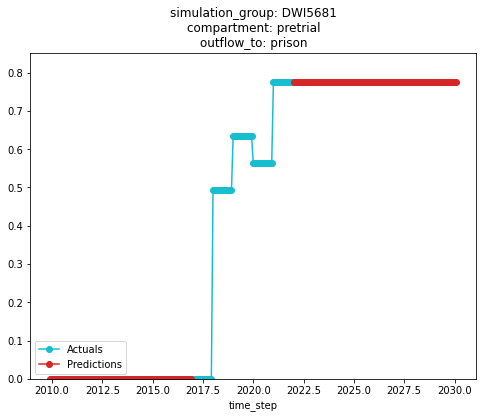

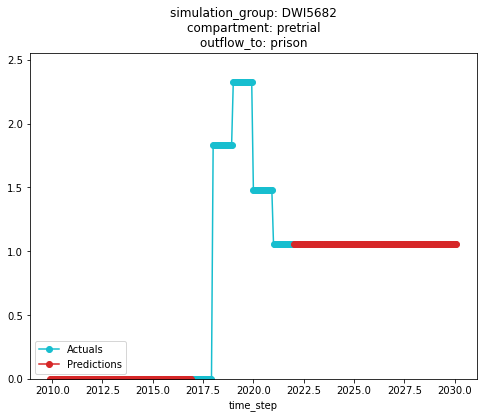

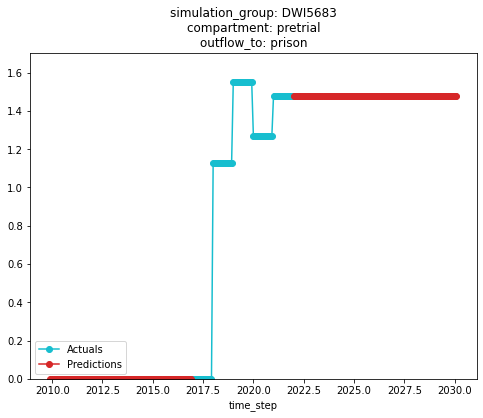

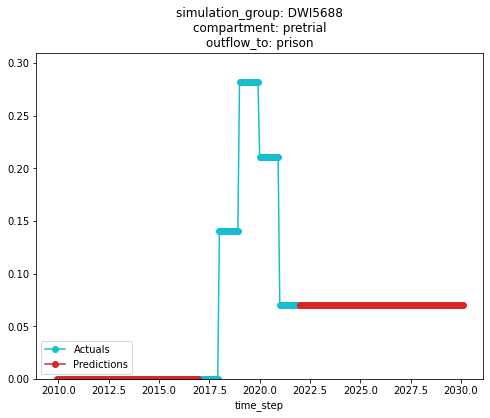

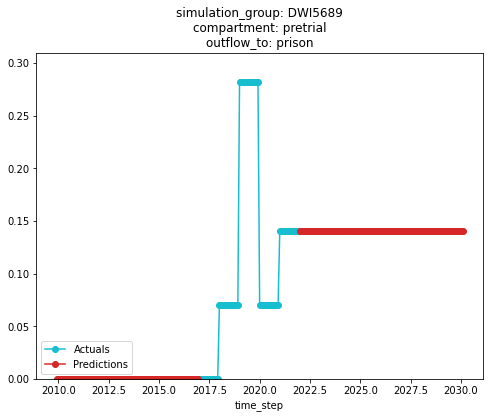

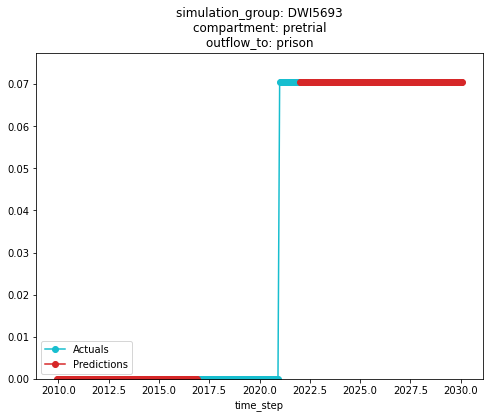

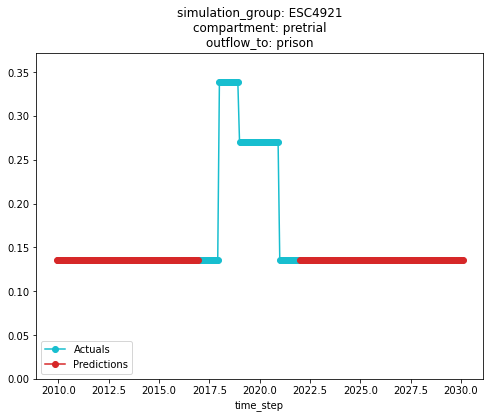

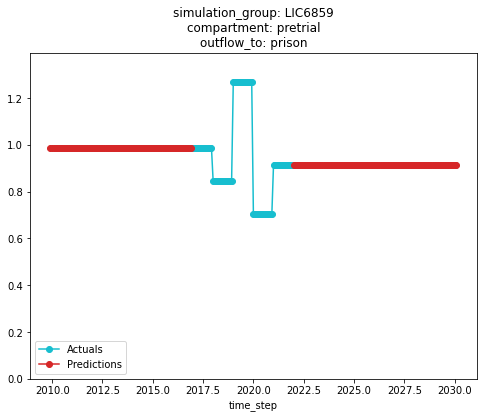

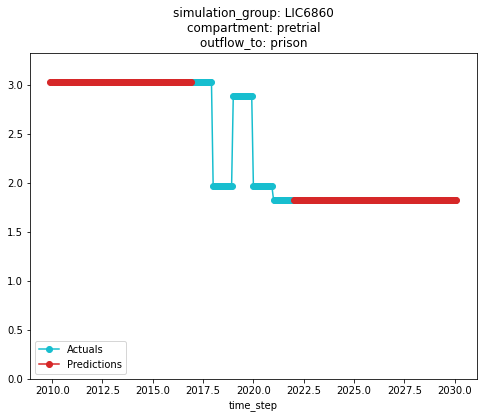

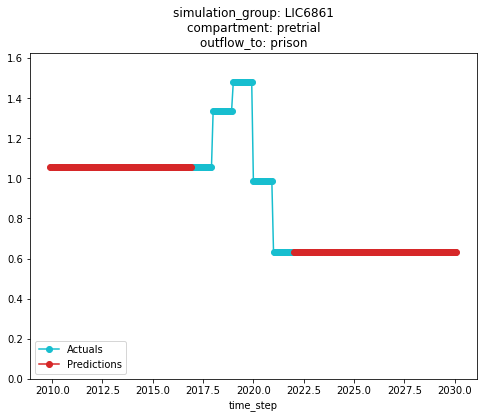

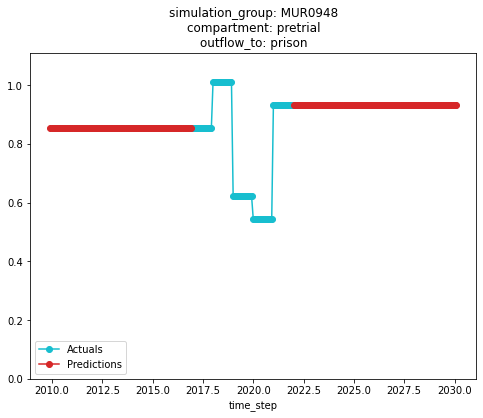

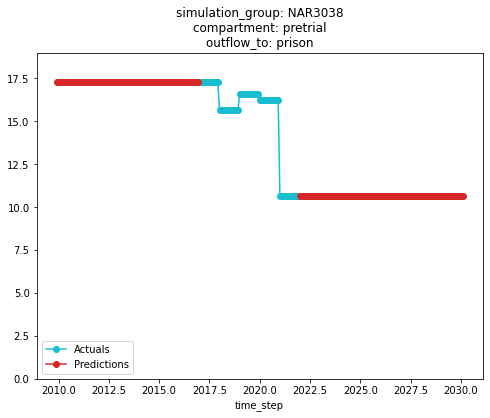

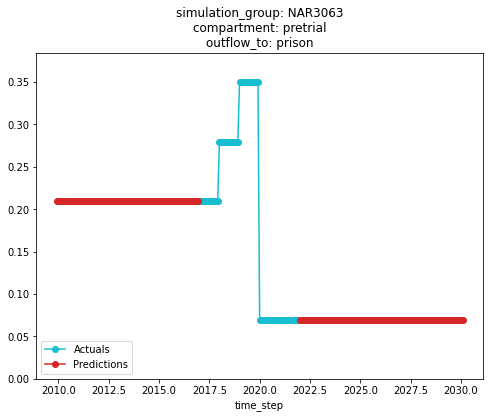

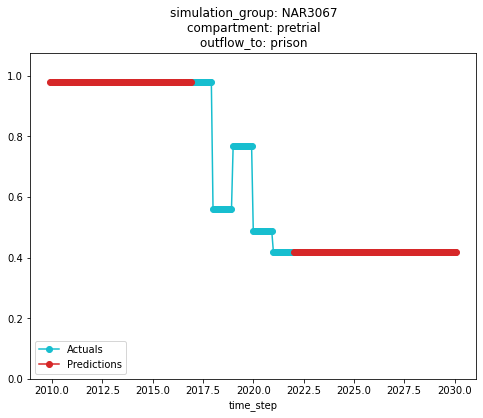

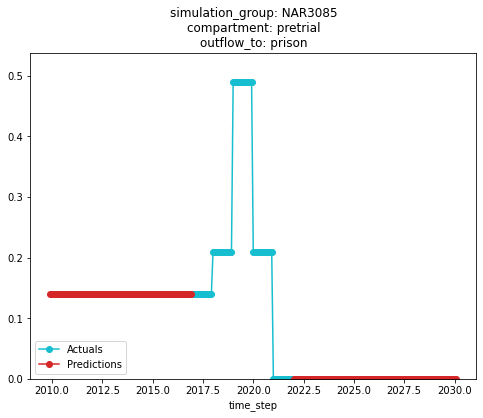

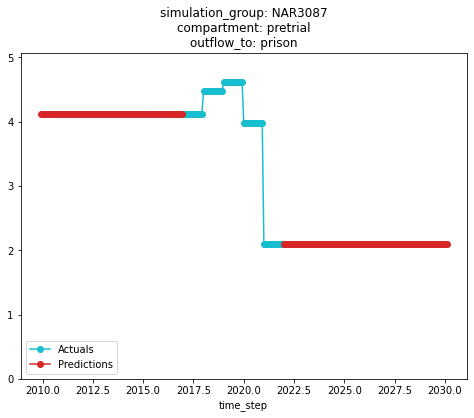

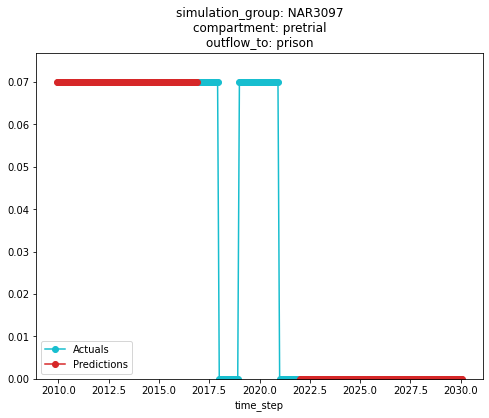

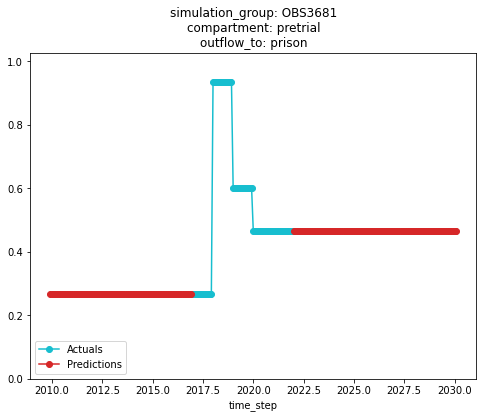

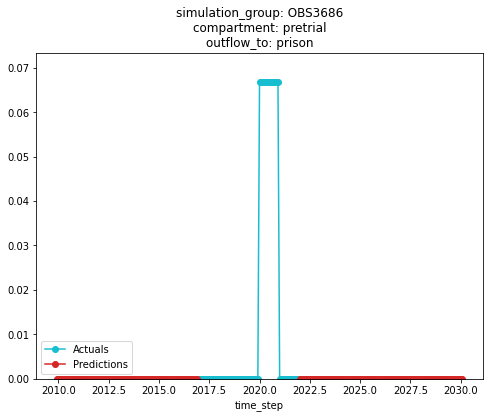

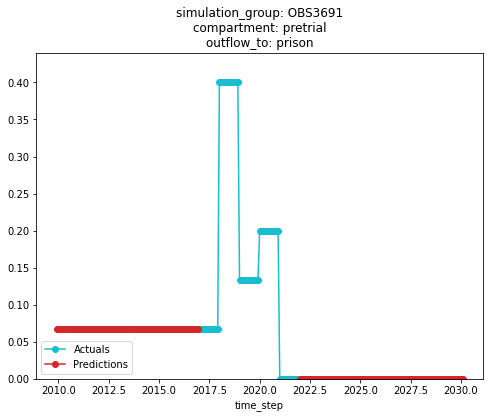

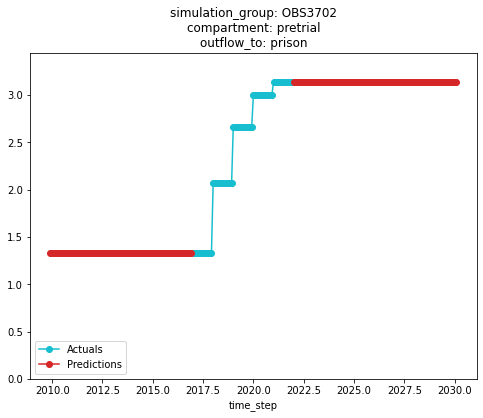

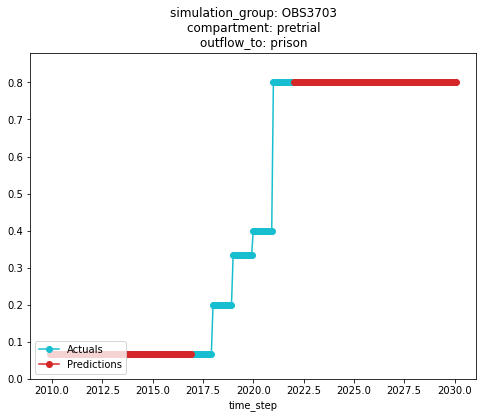

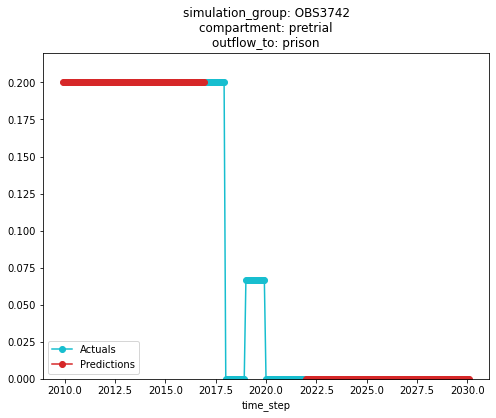

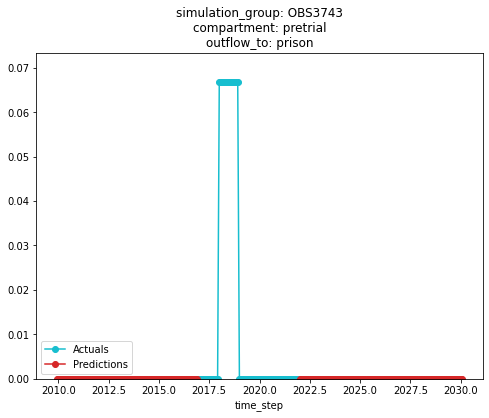

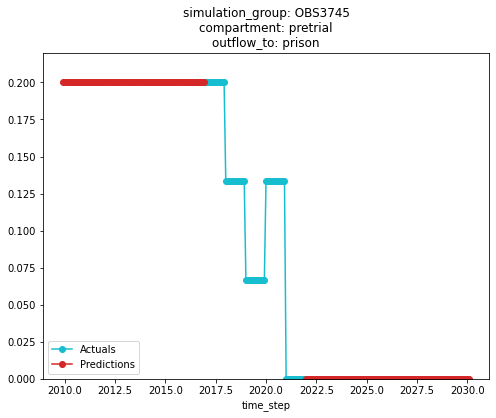

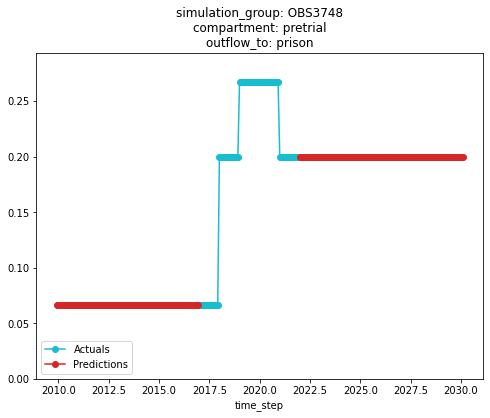

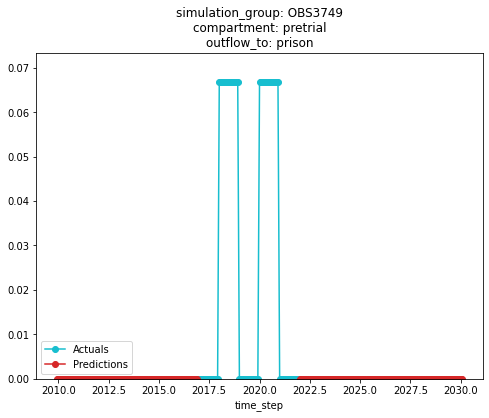

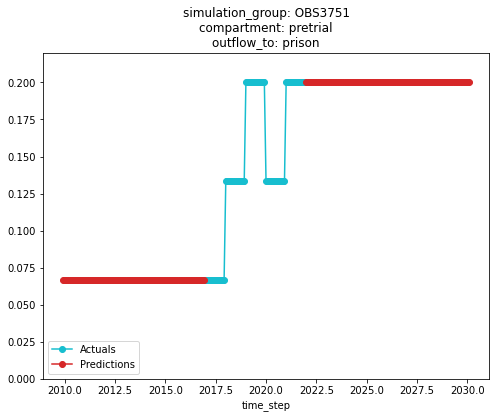

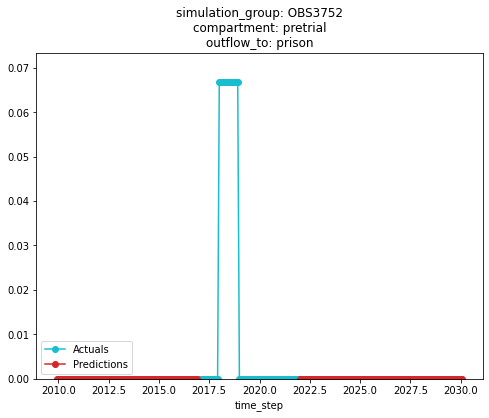

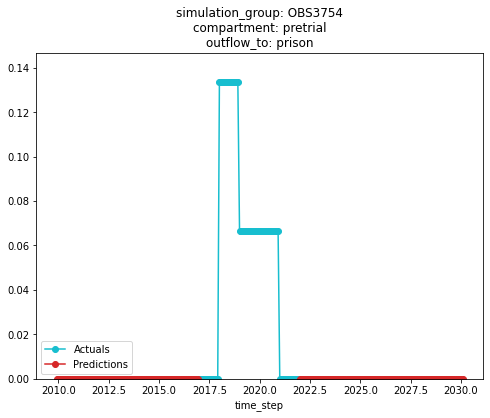

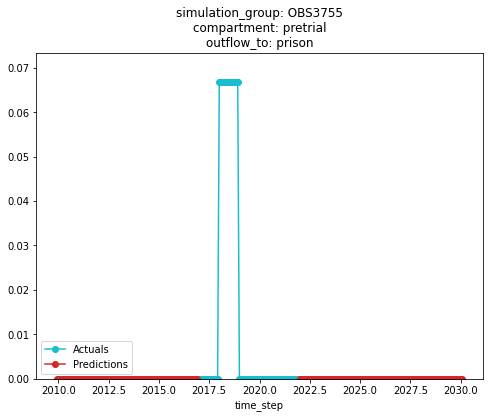

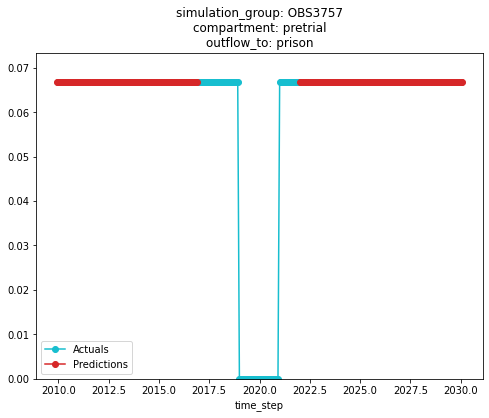

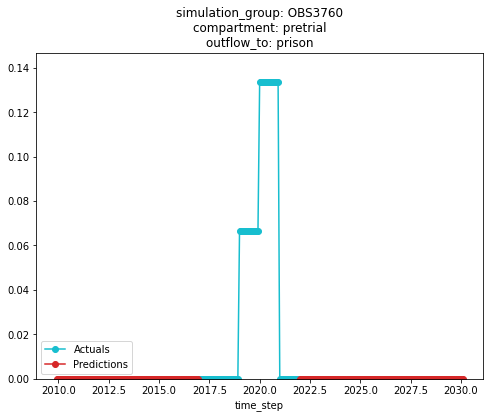

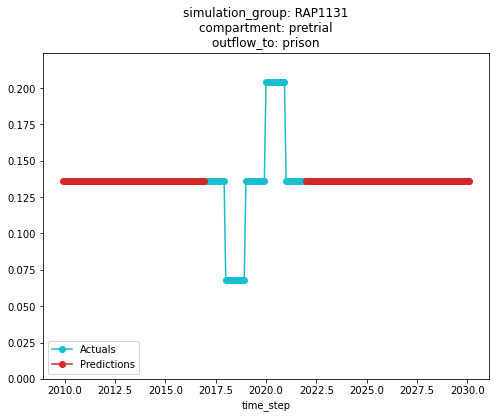

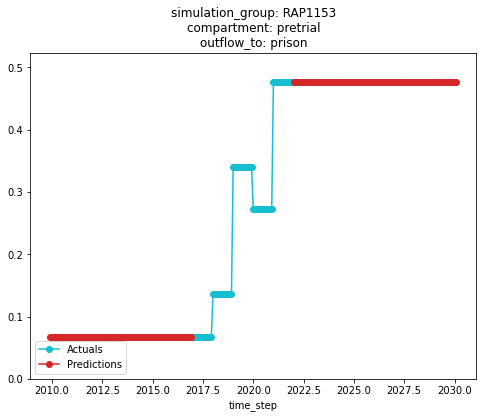

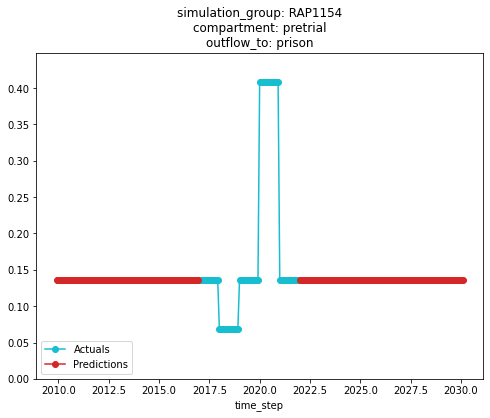

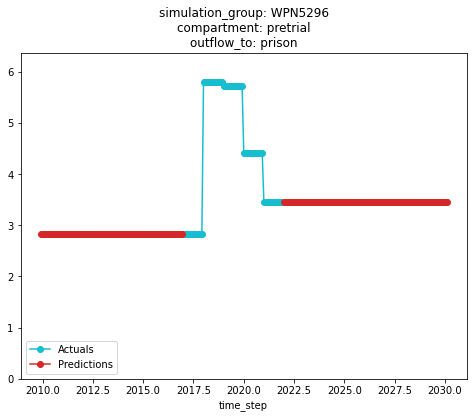

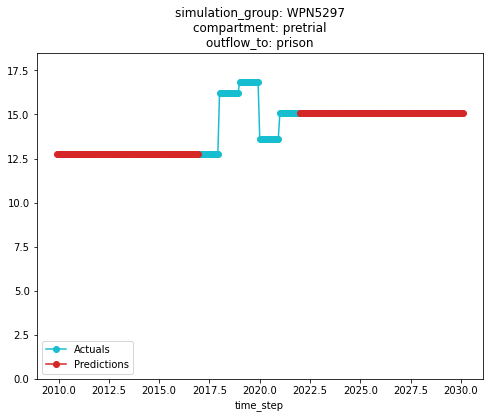

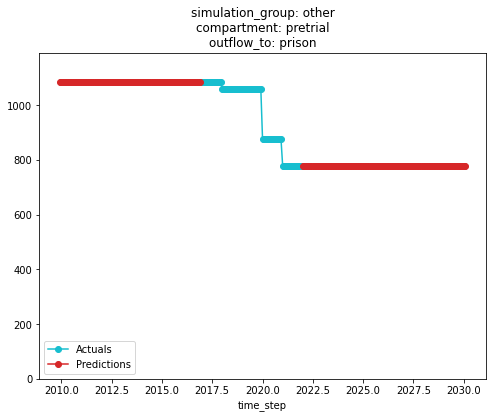

In [130]:
spark_sim.get_arima_output_plots('baseline_projections', by_simulation_group=True)

In [61]:
# Abolish mms

try:
    mms_stats = mms_stats.set_index('offense_code')
except:
    continue

RETROACTIVE = False

def get_reduction_size(crime_transitions, crime_mm):
    affected_fraction = crime_transitions[
        crime_transitions.compartment_duration == crime_mm
    ].total_population.sum() / crime_transitions.total_population.sum()
    
    average_duration = np.average(
        crime_transitions.compartment_duration,
        weights=crime_transitions.total_population,
    )
    
    variance = np.average(
        (crime_transitions.compartment_duration - average_duration) ** 2,
        weights=crime_transitions.total_population,
    )
    
    std = np.sqrt(variance)
    
    print(f'crime: {crime_transitions.iloc[0].crime} mm: {crime_mm} count: {len(crime_transitions)} \n average_duration: {average_duration}  std: {std}  affected_fraction: {affected_fraction}  scale factor: {affected_fraction * std / 2}')
    return affected_fraction * std

def abolish_mm(crime):
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': ['release'],
                       'reduction_size': [get_reduction_size(
                           non_enhanced_transitions[non_enhanced_transitions.crime == crime],
                           int(mms_stats.loc[crime].MM_clean)
                       )], 
                       'affected_fraction': [1]
                   }),
                   reduction_type='+',
                   retroactive=RETROACTIVE)

policy_list = [SparkPolicy(policy_fn=abolish_mm(crime),
                                           spark_compartment='prison',
                                           sub_population={'crime': crime},
                                           policy_ts=36,
                                           apply_retroactive=RETROACTIVE)
               for crime in non_enhanced_transitions.crime.unique() if crime != 'other'
              ]
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')

crime: ASL1342 mm: 6 count: 42 
 average_duration: 13.530456852791879  std: 9.876068065493651  affected_fraction: 0.20050761421319796  scale factor: 0.9901134228096427
crime: DWI5449 mm: 3 count: 26 
 average_duration: 6.658940397350993  std: 6.773015914096649  affected_fraction: 0.4685430463576159  scale factor: 1.5867247547097283
crime: NAR3038 mm: 36 count: 81 
 average_duration: 64.08212560386474  std: 43.34107718979007  affected_fraction: 0.27697262479871176  scale factor: 6.002145955429865
crime: WPN5297 mm: 24 count: 33 
 average_duration: 26.904545454545456  std: 12.412297565478942  affected_fraction: 0.6757575757575758  scale factor: 4.193852056214855
crime: LIC6861 mm: 12 count: 14 
 average_duration: 17.795454545454547  std: 8.09483433896004  affected_fraction: 0.38636363636363635  scale factor: 1.5637748154809166
crime: DWI5406 mm: 12 count: 22 
 average_duration: 17.849056603773583  std: 9.005022134248502  affected_fraction: 0.3584905660377358  scale factor: 1.614107741044

KeyboardInterrupt: 

crime: ASL1342 mm: 6 count: 42 
 average_duration: 13.530456852791879  std: 9.876068065493651  affected_fraction: 0.20050761421319796  scale factor: 0.9901134228096427
crime: DWI5449 mm: 3 count: 26 
 average_duration: 6.658940397350993  std: 6.773015914096649  affected_fraction: 0.4685430463576159  scale factor: 1.5867247547097283
crime: NAR3038 mm: 36 count: 81 
 average_duration: 64.08212560386474  std: 43.34107718979007  affected_fraction: 0.27697262479871176  scale factor: 6.002145955429865
crime: WPN5297 mm: 24 count: 33 
 average_duration: 26.904545454545456  std: 12.412297565478942  affected_fraction: 0.6757575757575758  scale factor: 4.193852056214855
crime: LIC6861 mm: 12 count: 14 
 average_duration: 17.795454545454547  std: 8.09483433896004  affected_fraction: 0.38636363636363635  scale factor: 1.5637748154809166
crime: DWI5406 mm: 12 count: 22 
 average_duration: 17.849056603773583  std: 9.005022134248502  affected_fraction: 0.3584905660377358  scale factor: 1.614107741044

simulation_time:  335.591509103775


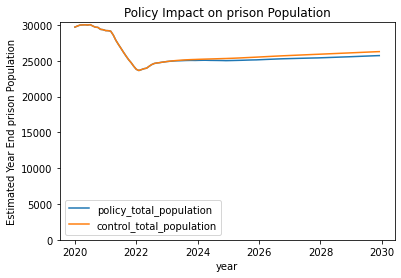

In [206]:
# Abolish mms

# mms_stats = mms_stats.set_index('offense_code')


RETROACTIVE = False

def get_reduction_size(crime_transitions, crime_mm):
    affected_fraction = crime_transitions[
        crime_transitions.compartment_duration == crime_mm
    ].total_population.sum() / crime_transitions.total_population.sum()
    
    average_duration = np.average(
        crime_transitions.compartment_duration,
        weights=crime_transitions.total_population,
    )
    
    variance = np.average(
        (crime_transitions.compartment_duration - average_duration) ** 2,
        weights=crime_transitions.total_population,
    )
    
    std = np.sqrt(variance)
    
    print(f'crime: {crime_transitions.iloc[0].crime} mm: {crime_mm} count: {len(crime_transitions)} \n average_duration: {average_duration}  std: {std}  affected_fraction: {affected_fraction}  scale factor: {affected_fraction * std / 2}')
    return affected_fraction * std

def abolish_mm(crime):
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': ['release'],
                       'reduction_size': [get_reduction_size(
                           non_enhanced_transitions[non_enhanced_transitions.crime == crime],
                           int(mms_stats.loc[crime].MM_clean)
                       )], 
                       'affected_fraction': [1]
                   }),
                   reduction_type='+',
                   retroactive=RETROACTIVE)

policy_list = [SparkPolicy(policy_fn=abolish_mm(crime),
                                           spark_compartment='prison',
                                           sub_population={'crime': crime},
                                           policy_ts=36,
                                           apply_retroactive=RETROACTIVE)
               for crime in non_enhanced_transitions.crime.unique() if crime != 'other'
              ]
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')

(array([1., 0., 3., 3., 8., 5., 4., 4., 4., 5., 4., 2., 3., 0., 3., 2., 4.,
        1., 2., 1., 2., 0., 2., 1., 2., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 0., 1.]),
 array([   0.,   30.,   60.,   90.,  120.,  150.,  180.,  210.,  240.,
         270.,  300.,  330.,  360.,  390.,  420.,  450.,  480.,  510.,
         540.,  570.,  600.,  630.,  660.,  690.,  720.,  750.,  780.,
         810.,  840.,  870.,  900.,  930.,  960.,  990., 1020., 1050.,
        1080., 1110., 1140., 1170., 1200.]),
 <BarContainer object of 40 artists>)

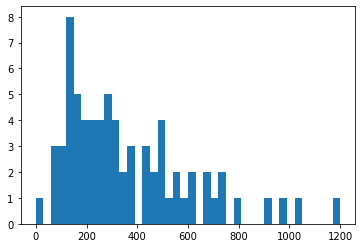

In [180]:
plt.hist(non_enhanced_transitions[(non_enhanced_transitions.crime == 'NAR3038')].compartment_duration, bins=40)

In [207]:
# maybe don't run this one yourself, no need to spam our output database :)
simulation_tag = 'VA_all_mms_dec_29'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                       prison release release_full
 year                                             
 2020.000000              0.0     0.0          0.0
 2020.083333              0.0     0.0          0.0
 2020.166667              0.0     0.0          0.0
 2020.250000              0.0     0.0          0.0
 2020.333333              0.0     0.0          0.0
 2020.416667              0.0     0.0          0.0
 2020.500000              0.0     0.0          0.0
 2020.583333              0.0     0.0          0.0
 2020.666667              0.0     0.0          0.0
 2020.750000              0.0     0.0          0.0
 2020.833333              0.0     0.0          0.0
 2020.916667              0.0     0.0          0.0
 2021.000000              0.0     0.0          0.0
 2021.083333              0.0     0.0          0.0
 2021.166667              0.0     0.0          0.0
 2021.250000              0.0     0.0          0.0
 2021.333333              0.0     0.0          0.0
 2021.416667  

In [183]:
test_results

,compartment,year,policy_total_population,simulation_group,control_total_population
year,,,,,
2020.000000,prison,2020.000000,2.453578,ASL1319,2.453578
2020.083333,prison,2020.083333,2.410681,ASL1319,2.410681
2020.166667,prison,2020.166667,2.365580,ASL1319,2.365580
2020.250000,prison,2020.250000,2.310167,ASL1319,2.310167
2020.333333,prison,2020.333333,2.253626,ASL1319,2.253626
...,...,...,...,...,...
2029.583333,release_full,2029.583333,159511.556593,other,159511.556593
2029.666667,release_full,2029.666667,160276.739909,other,160276.739909
2029.750000,release_full,2029.750000,161042.124297,other,161042.124297


In [215]:
life_years = pd.DataFrame()
for crime in test_results.simulation_group.unique():
    group_data = test_results[
        (test_results.simulation_group == crime) &
        (test_results.compartment == 'prison') & 
        (test_results.year >= 2027)
    ]
    life_years[crime] = group_data.control_total_population - group_data.policy_total_population

impact_by_crime = life_years.loc[2028] / life_years.loc[2028].sum() * 100
impact_by_crime 

ASL1319     0.039340
ASL1326     0.000000
ASL1330     0.116117
ASL1342    10.592999
DWI5406     1.261131
DWI5449     7.334058
DWI5450     3.640844
DWI5493     3.794577
DWI5680     0.228126
DWI5681     0.201754
DWI5682     0.577944
DWI5683     0.833844
DWI5688     0.027994
DWI5689     0.072855
DWI5693     0.000000
ESC4921     0.175864
LIC6859     0.301815
LIC6860     0.340021
LIC6861     0.459321
MUR0948     0.000000
NAR3038    17.776096
NAR3063     0.158746
NAR3067     0.903518
NAR3085     0.097838
NAR3087     3.980608
NAR3097     0.000000
OBS3681     0.080537
OBS3686     0.000000
OBS3691     0.019769
OBS3702     8.356768
OBS3703     0.000000
OBS3742     0.000000
OBS3745     0.025364
OBS3748     0.000000
OBS3749     0.000000
OBS3751     0.000000
OBS3754     0.013859
OBS3757     0.000000
OBS3760     0.000000
RAP1131     0.138928
RAP1153     0.000000
RAP1154     0.192177
WPN5296    10.411232
WPN5297    27.845957
other       0.000000
Name: 2028.0, dtype: float64